In [1]:
import pandas as pd
import numpy as np
import os
import models
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from nltk.corpus import stopwords
import re
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.layers import Input, Dense, Embedding, Flatten, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.models import Model
from keras.utils import np_utils
from time import time

Using TensorFlow backend.


In [2]:
english_stopwords = set(stopwords.words('english'))
categories = ['Democrat', 'Republican']
tweetsdf = pd.read_csv('democratvsrepublicantweets/ExtractedTweets.csv')
handlesdf = pd.read_csv('democratvsrepublicantweets/TwitterHandles.csv')
raw_tweets = tweetsdf['Tweet']
parties = tweetsdf['Party']

In [76]:
def tokenize_tweet(s):
    s = s.lower()
    s = re.sub(r'https?://[^\s]+', '', s)
    s = re.sub(r'[^A-Za-z\s$#@0-9]+', '', s)
    s = re.sub(r'\s+', ' ', s)
    return [tok for tok in s.strip().split(' ') if tok not in english_stopwords]
    
tokenized_tweets = [tokenize_tweet(tweet) for tweet in raw_tweets]

vocab = {}
for toks in tokenized_tweets:
    for tok in toks:
        if tok in vocab:
            vocab[tok] += 1
        else:
            vocab[tok] = 1
            
vocab = {k:v for k,v in vocab.items() if v > 10}

vocabulary = list(vocab.keys())
vocabulary_size = len(vocabulary) + 1

word_to_int = {word: i + 1 for i, word in enumerate(vocabulary)}
int_to_word = {i + 1: word for i, word in enumerate(vocabulary)}

In [78]:
encoded_tweets =\
    [[word_to_int.get(tok, 0) for tok in toks if tok in word_to_int]
     for toks in tokenized_tweets]

max_tweet_len = max([len(encoded_tweet) for encoded_tweet in encoded_tweets])

X = []
for encoded_tweet in encoded_tweets:
    v = np.zeros(max_tweet_len)
    v[0:len(encoded_tweet)] = encoded_tweet
    X.append(v)
    
X = np.array(X)

y = 1.0 - np.asarray(parties == 'Democrat')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
print('Max tweet length: %s' % max_tweet_len)

Max tweet length: 28


In [87]:
def model8(vocabulary_size, max_tweet_len):
    input_layer = Input(shape=(max_tweet_len,))
    x = Embedding(output_dim=100, input_dim=vocabulary_size, input_length=max_tweet_len)(input_layer)
    x = Conv1D(128, kernel_size=4, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=4, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(input_layer, x)
    optimizer = Adam(lr=0.0003)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return 'word-embedding2.hdf5', model

In [89]:
filepath, model = model8(vocabulary_size, max_tweet_len)
if filepath in os.listdir():
    model.load_weights(filepath)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 28, 100)           873700    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 25, 128)           51328     
_________________________________________________________________
dropout_7 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 12, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 9, 64)             32832     
_________________________________________________________________
dropout_8 (Dropout)          (None, 9, 64)             0         
__________

In [90]:
models.train(X_train, y_train, model, filepath)

Epoch 1/100
69168/69168 [==============================] - 9s 132us/step - loss: 0.6835

Epoch 00001: loss improved from inf to 0.68345, saving model to word-embedding2.hdf5
Epoch 2/100
69168/69168 [==============================] - 10s 146us/step - loss: 0.5310

Epoch 00002: loss improved from 0.68345 to 0.53100, saving model to word-embedding2.hdf5
Epoch 3/100
69168/69168 [==============================] - 11s 166us/step - loss: 0.4169

Epoch 00003: loss improved from 0.53100 to 0.41686, saving model to word-embedding2.hdf5
Epoch 4/100
69168/69168 [==============================] - 10s 150us/step - loss: 0.3766

Epoch 00004: loss improved from 0.41686 to 0.37661, saving model to word-embedding2.hdf5
Epoch 5/100
69168/69168 [==============================] - 12s 176us/step - loss: 0.3552

Epoch 00005: loss improved from 0.37661 to 0.35522, saving model to word-embedding2.hdf5
Epoch 6/100
69168/69168 [==============================] - 15s 214us/step - loss: 0.3377

Epoch 00006: loss im

69168/69168 [==============================] - 11s 154us/step - loss: 0.0197

Epoch 00047: loss did not improve from 0.01885
Epoch 48/100
69168/69168 [==============================] - 13s 182us/step - loss: 0.0189

Epoch 00048: loss did not improve from 0.01885
Epoch 49/100
69168/69168 [==============================] - 12s 174us/step - loss: 0.0193

Epoch 00049: loss did not improve from 0.01885
Epoch 50/100
69168/69168 [==============================] - 12s 173us/step - loss: 0.0188

Epoch 00050: loss improved from 0.01885 to 0.01880, saving model to word-embedding2.hdf5
Epoch 51/100
69168/69168 [==============================] - 12s 167us/step - loss: 0.0173

Epoch 00051: loss improved from 0.01880 to 0.01732, saving model to word-embedding2.hdf5
Epoch 52/100
69168/69168 [==============================] - 11s 156us/step - loss: 0.0174

Epoch 00052: loss did not improve from 0.01732
Epoch 53/100
69168/69168 [==============================] - 13s 192us/step - loss: 0.0183

Epoch 0005

In [91]:
predictions = np.argmax(model.predict(X_test), axis=1)

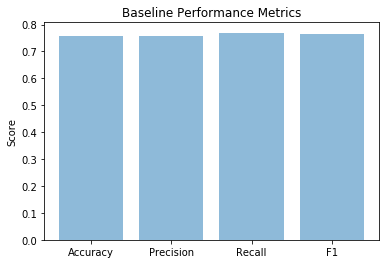

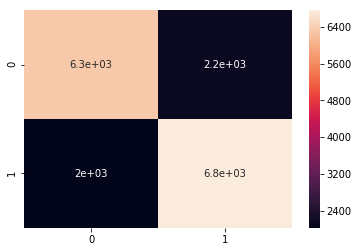

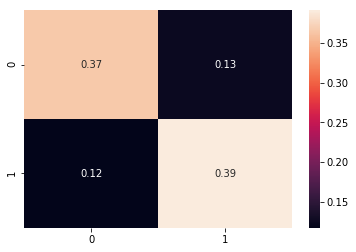

Accuracy: 0.7574600971547536
Accuracy: 0.7570532915360502
Accuracy: 0.7696335078534031
Accuracy: 0.7632915678970538


In [92]:
(accuracy, precision, recall, f1), confusion_matrix = models.plot_results(y_test, predictions)
print('Accuracy: %s' % accuracy)
print('Accuracy: %s' % precision)
print('Accuracy: %s' % recall)
print('Accuracy: %s' % f1)